In [2]:
import math
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from ucimlrepo import fetch_ucirepo 

heart_disease = fetch_ucirepo(id=45) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

1. The Cleveland Clinic dataset has various attributes related to patient health, including age, sex, blood pressure, cholesterol levels, etc. The goal of the classification problem is to predict whether a patient has heart disease or not based on these attributes. A patient is classified as having heart disease if their severity level is greater than 0, and as not having heart disease if their severity level is equal to 0. 

2. We standardized the data to give each feature a mean of 0 and a standard deviation of 1. This is important for algorithms like logistic regression because it prevents any single feature from dominating others due to its scale. 

In [3]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns)

3. The dataset contains 303 observations, each representing a patient. It includes 13 features: age, sex, chest pain type, resting blood pressure, cholesterol levels, fasting blood sugar, resting electrocardiogram results, maximum heart rate achieved, exercise-induced angina, depression induced by exercise, slope of the peak exercise ST segment, number of major vessels, and thalassemia.

The dataset contains continuous variables like age and cholesterol, binary variables such as sex and exercise-induced angina, and categorical variables like chest pain type and thalassemia.

In [4]:
print("number of observations: ", X.shape[0])
print("columns:",X.columns.tolist())

number of observations:  303
columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


Here is a more detailed breakdown of the dataset distrbitution. 

In [5]:
summary_df = abs(round(X_scaled.describe(),2))
summary_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,299.00,301.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,2.82,1.46,2.25,2.15,2.33,0.42,1.00,3.44,0.70,0.90,0.98,0.72,0.90
25%,0.71,1.46,0.17,0.67,0.69,0.42,1.00,0.71,0.70,0.90,0.98,0.72,0.90
50%,0.17,0.69,0.17,0.10,0.11,0.42,0.01,0.15,0.70,0.21,0.65,0.72,0.90
75%,0.73,0.69,0.88,0.47,0.55,0.42,1.02,0.72,1.44,0.48,0.65,0.35,1.17
max,2.50,0.69,0.88,3.89,6.14,2.39,1.02,2.29,1.44,4.45,2.27,2.49,1.17


Using a violin plot, we plotted the distribution of the variables. We can see that the categorical variables are more easily defined by their two peak shape.

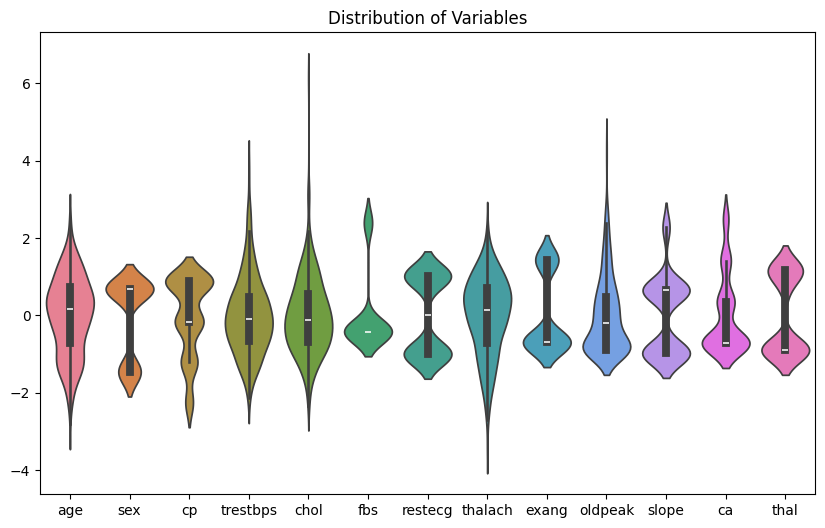

In [6]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=X_scaled)  
plt.title("Distribution of Variables")
plt.show()

4. Now, we transformed the response num into a binary outcome: 1 for heart disease and 0 for no heart disease. 

In [7]:
y_response = (y > 0).astype(int)

6. We dropped any missing values. 

In [8]:
features = X_scaled.dropna()
target = y_response.loc[features.index]

print(f"Number of observations after removing missing values: {len(features)}")

Number of observations after removing missing values: 297


7. To explore different subgroups in the data, we used k-means clustering and chose the best number of clusters based on the highest silhouette score. We then used PCA to reduce the data to two dimensions, plotting the first principal component against the second principle component to show how the clusters separate. We excluded the features defined as categorical according to the data description found on the website. 

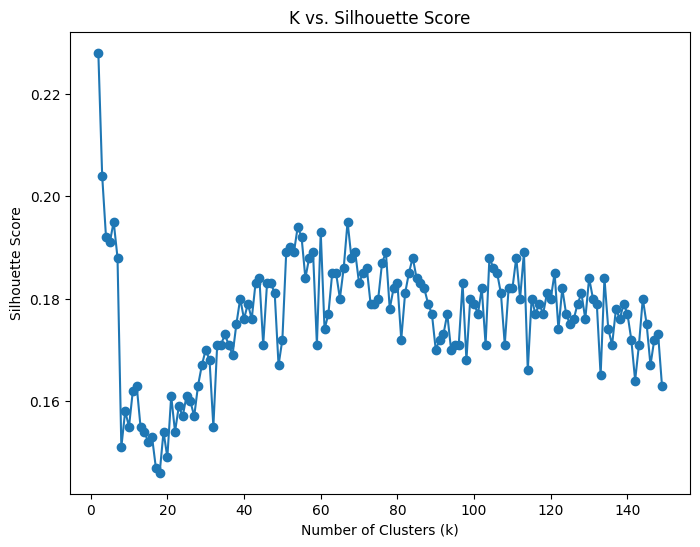

In [9]:
non_categorical_features = features.drop(columns=["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"])

scores = []
k_values = range(2, 150, 1)

for k in k_values:
    km2 = KMeans(n_clusters=k, n_init=20, random_state=0)
    km2.fit(non_categorical_features)
    labels = km2.labels_
    score = round(silhouette_score(non_categorical_features, labels),3)
    scores.append(score)

scores = np.array(scores)

plt.figure(figsize=(8,6))
plt.plot(k_values, scores, marker='o')
plt.title("K vs. Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

The graph confirms that the optimal number of clusters is k = 2. Now we can graph the clusters using the first two principle components. 

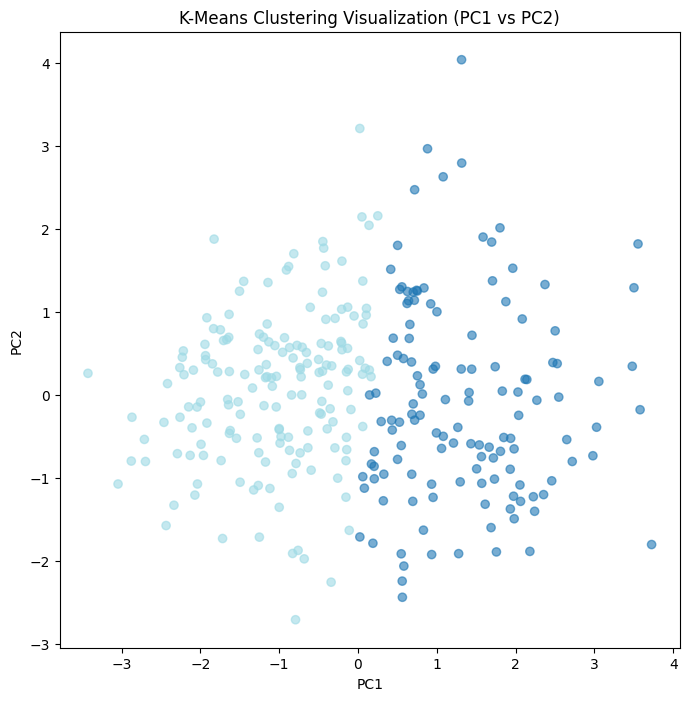

In [10]:
pca_non_categorical = PCA()
pc_data = pca_non_categorical.fit_transform(non_categorical_features)

pca_loadings = pd.DataFrame(
    pca_non_categorical.components_.T,
    index=non_categorical_features.columns,
    columns=[f"PC{i+1}" for i in range(pca_non_categorical.n_components_)])

pc_scores = pd.DataFrame(
    pc_data,
    index=non_categorical_features.index,
    columns=[f"PC{i+1}" for i in range(pca_non_categorical.n_components_)])

num_components = pca_non_categorical.n_components_
pc_indices = np.arange(1, num_components + 1)
pc_scores = pc_scores.iloc[:, :6]
km = KMeans(n_clusters=2, n_init=20, random_state=0)
cluster_labels_km = km.fit_predict(non_categorical_features)
pc_scores['cluster'] = cluster_labels_km

plt.figure(figsize=(8, 8))
plt.scatter(
    pc_scores['PC1'],
    pc_scores['PC2'],
    c=pc_scores['cluster'],
    cmap='tab20',
    alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering Visualization (PC1 vs PC2)')
plt.show()

8. Split data for testing and training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

9. For this analysis, we selected logistic regression and random forest as our classifiers. Logistic regression was chosen because is well-suited for binary classification tasks like this one. Random forest was selected as a second method because it can capture more complicated relationships through its decision trees. 

10. We chose accuracy and F1 as methods to compare classifier performance.
 - Accuracy measures the proportion of correct predictions and is computed as (TP + TN) divided by the total number of predictions.
 - The F1 score is calculated as 2TP/(2TP+FP+FN)

11. Training 

In [12]:
# logistic regression 

# fit and predict the model 
log1 = LogisticRegression(max_iter=120)
log1.fit(X_train, y_train.values.ravel())
pred_probabilities = log1.predict_proba(X_test)
predicted_probability = log1.predict_proba(X_test)[:, 1]
y_pred = (predicted_probability >= 0.63).astype(int)

# calculate the true and false positives from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = f1_score(y_test, y_pred)

# output results
print("Logistic Regression")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")

# get optimal probaiblity cutoff
fpr, tpr, thresholds = roc_curve(y_test, predicted_probability)
j_statistic = tpr - fpr
optimal_index = np.argmax(j_statistic)
optimal_threshold = thresholds[optimal_index]

print(f"Optimal probability cutoff: {optimal_threshold:.2f}")

Logistic Regression
Accuracy: 0.833
F1 Score: 0.805
Optimal probability cutoff: 0.63


The second model we fitted was a random forest classifier with paramters of 100 trees.

In [13]:
# random forest
# fit the and predict the model 
heart_disease = RandomForestClassifier (
    n_estimators = 100,
    random_state=1, 
    bootstrap=True, 
    oob_score=True,
    criterion='gini')

heart_disease.fit(X_train, y_train.values.ravel())
y_pred = heart_disease.predict(X_test)

# Calculate accuracy and f1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Random Forest")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")

Random Forest
Accuracy: 0.889
F1 Score: 0.875


12. We chose to apply ellastic net to the logistic regression classifier. 

In [14]:
enet_cv = LogisticRegressionCV(
    penalty='elasticnet',
    solver='saga',              # required for elasticnet
    l1_ratios=[0.1, 0.5, 0.9],  # l1_ratios (alpha in the lectures)
    Cs=10,                      # number of C values to try (or pass a list) - 1/lambda
    cv=5,
    max_iter=10000,
    scoring='accuracy',
    refit=True)
enet_cv.fit(X_train, y_train.values.ravel())

m_enet = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    C=enet_cv.C_[0],              # best C from cross-validation (1/lambda)
    l1_ratio=enet_cv.l1_ratio_[0],# best l1_ratio from cross-validation
    max_iter=10000)
y_pred = m_enet.fit(X_train, y_train.values.ravel()).predict(X_test)
f1_2 = f1_score(y_test, y_pred)

m_enet_pre = m_enet.predict(X_test)
print("Elastic Net Feature Selection")
print("Accuracy:",round(accuracy_score(y_test.values.ravel(), m_enet_pre),3))
print("F1 Score:",round(f1_2,3))

Elastic Net Feature Selection
Accuracy: 0.878
F1 Score: 0.857


13. After training and testing the models, the random forest achieved an accuracy of 88.9% and an f1 score of 87.5%, outperforming logistic regression, which scored 83.3% accuracy and an 80.5% f1 score. This is a signifant difference because it means 5.2% more patients are correcty diagnosed under random forest. After applying a feature selection, the model performances between the two methods equalize and the logistic regression acheives an accuracy of 87.8% and an f1 score of 87.5%. 

14. For the best interpretable model identified in (13), analyze and interpret the most important predictor variables in the context of the classification challenge (at least two statements).

In [15]:
pd.DataFrame({'Feature': X_train.columns, 'Coefficient': m_enet.coef_.reshape(len(X_train.columns))})

,Feature,Coefficient
0,age,0.054013
1,sex,0.329586
2,cp,0.324235
3,trestbps,0.175039
4,chol,0.054157
5,fbs,-0.140907
6,restecg,0.139418
7,thalach,-0.281434
8,exang,0.275582
9,oldpeak,0.332751


We can see that the variables that influence the classifier the most are those with the largest coefficient magnitudes. The top three would be number of vessels, thalassemia, and ST depression at peak exercise. Surpringly, age and chol don't appear to influence the model significantly. 

16. We established what should be implemented and how it should be done for each question together. Just to make sure we're on the same page. Then for the implementation, Saul worked on questions 1-8 and Fanny worked on questions 9-14. Then we committed our respective portions to github. 

17. Link to the public GitHub repository. 
   
https://github.com/SaulWidrich/A6-G49